In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aftabhussaincui/refined-rnsa-ct-scans-12k-pngs
! unzip refined-rnsa-ct-scans-12k-pngs.zip

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, SpatialDropout2D ,BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil
from random import uniform

In [6]:
learning_rate = 1e-4
batch_size = 34
epochs_number = 100

In [7]:
dataset_path = 'RNSA_Subset_PNGs_12K'

In [8]:
! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'

In [9]:


# Get a list of all the folders in the dataset directory
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.22, 0.03
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]


In [ ]:
test_set

In [10]:
for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in ['Normal', 'Epidural_Positive','Intraventricular_Positive', 'Subdural_Positive', 'Intraparenchymal_Positvie', 'Subarachnoid_Positive', 'Any_Positive']:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 9000
Validation set size: 2640
Test set size: 360


In [17]:
def initialize_model(name):
  model = tf.keras.models.Sequential(name=name)
      # Convolutional layer 1
  model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=(2, 2), activation='relu', input_shape=(256, 256, 3)))
  model.add(SpatialDropout2D(0.3))
  model.add(BatchNormalization())
      # Convolutional layer 2
  model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
      # Convolutional layer 3
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  model.add(SpatialDropout2D(0.3))
  # model.add(BatchNormalization())
      # Convolutional layer 4
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  model.add(SpatialDropout2D(0.4))
      # Convolutional layer 5
  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
  # model.add(SpatialDropout2D(0.2))
  model.add( MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
  # model.add(SpatialDropout2D(0.2))
      # Flatten the output from convolutional layers
  model.add(Flatten())
  # model.add(Dropout(uniform(0, 1)))
      # Fully-connected layer 1
  model.add(Dense(units=4026, activation='relu'))
  model.add(Dropout(uniform(0, 1)))
      # Fully-connected layer 2
  model.add(Dense(units=4026, activation='relu'))
  model.add(Dropout(uniform(0, 1)))
  model.add (Dense(units=7, activation='softmax'))
  return model

In [18]:
model = initialize_model(name="ZFnet")
model.summary()

Model: "ZFnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 125, 125, 96)      14208     
                                                                 
 spatial_dropout2d_7 (Spatia  (None, 125, 125, 96)     0         
 lDropout2D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 96)     384       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                             

In [19]:
def compile_model(model):
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [21]:
train_data = train_datagen.flow_from_directory('RNSA_Subset_PNGs_12K/Train', 
                                               target_size = (256, 256), 
                                               batch_size = batch_size, 
                                               class_mode = 'categorical')
validation_data = train_datagen.flow_from_directory('RNSA_Subset_PNGs_12K/Validation', 
                                                    target_size = (256, 256), 
                                                    batch_size = batch_size, 
                                                    class_mode = 'categorical')
# test_data = test_datagen.flow_from_directory('RNSA_Subset_PNGs_12K/Test', 
#                                               target_size = (256, 256), 
#                                               batch_size = batch_size, 
#                                               class_mode = 'categorical')

Found 6003 images belonging to 7 classes.
Found 2241 images belonging to 7 classes.
Found 353 images belonging to 7 classes.


In [22]:
model = compile_model(model)
res_history = model.fit(train_data, 
                        validation_data = validation_data, 
                        epochs = 60, 
                        steps_per_epoch = len(train_data), 
                        validation_steps = len(validation_data))

Epoch 1/60
177/177 [==============================] - 78s 347ms/step - loss: 1.9751 - accuracy: 0.2331 - val_loss: 1.9334 - val_accuracy: 0.4110
Epoch 2/60
177/177 [==============================] - 61s 342ms/step - loss: 1.8767 - accuracy: 0.2434 - val_loss: 1.8790 - val_accuracy: 0.4016
Epoch 3/60
177/177 [==============================] - 65s 368ms/step - loss: 1.8573 - accuracy: 0.2370 - val_loss: 1.8101 - val_accuracy: 0.3860
Epoch 4/60
177/177 [==============================] - 60s 338ms/step - loss: 1.8447 - accuracy: 0.2419 - val_loss: 1.8867 - val_accuracy: 0.2735
Epoch 5/60
177/177 [==============================] - 60s 340ms/step - loss: 1.8365 - accuracy: 0.2450 - val_loss: 1.7858 - val_accuracy: 0.3793
Epoch 6/60
177/177 [==============================] - 65s 365ms/step - loss: 1.8250 - accuracy: 0.2512 - val_loss: 1.7377 - val_accuracy: 0.3699
Epoch 7/60
177/177 [==============================] - 60s 339ms/step - loss: 1.8148 - accuracy: 0.2584 - val_loss: 1.7310 - val_ac

In [23]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

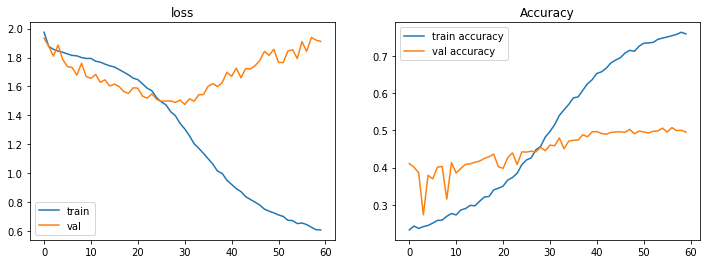

In [24]:
plot_history(res_history, title='', axs=None, exp_name="");